In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from pingouin import bayesfactor_ttest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-liwc-proportional.pkl")
mask_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_adhd
features = df.columns[-64:].tolist()

## Necessary functions

In [3]:
def univariate_liwc(df, features, mask_g1, mask_g2, alpha=0.05):
    """
    For each LIWC feature:
      - Welch’s t-test
      - JZS Bayes factor
      - Cohen’s d
    Returns a DataFrame with p-values, BF10, d, FDR‐corrected p’s, etc.
    """
    rows = []
    for feat in features:
        g1 = df.loc[mask_g1, feat].dropna()
        g2 = df.loc[mask_g2, feat].dropna()
        t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
        n1, n2 = len(g1), len(g2)
        bf10 = bayesfactor_ttest(t_stat, n1, n2, paired=False)
        s1, s2 = g1.std(ddof=1), g2.std(ddof=1)
        s_pool = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
        d = (g1.mean() - g2.mean())/s_pool
        rows.append({
            'feature': feat,
            'mean_g1': g1.mean(),
            'sd_g1': s1,
            'mean_g2': g2.mean(),
            'sd_g2': s2,
            't_stat': t_stat,
            'p_val': p_val,
            'bf10': bf10,
            'cohen_d': d
        })
    df_res = pd.DataFrame(rows)
    _, p_corr, _, _ = multipletests(df_res['p_val'], method='fdr_bh')
    df_res['p_fdr'] = p_corr
    df_res['signif'] = df_res['p_fdr'] < alpha
    df_res['abs_cohen_d'] = df_res['cohen_d'].abs()
    return df_res.sort_values('abs_cohen_d', ascending=False)

In [4]:
def pca_group_diff(df, features, mask_g1, mask_g2, n_pc=5, alpha=0.05):
    """
    Standardize LIWC features, run PCA, perform Welch’s t-test on each PC
    Returns a DataFrame of PC, explained_variance, t_stat, p_val, p_fdr.
    """
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_pc)
    pcs = pca.fit_transform(Xs)
    rows = []
    for i in range(n_pc):
        comp = pcs[:, i]
        t, p = stats.ttest_ind(comp[mask_g1], comp[mask_g2], equal_var=False)
        rows.append({
            'PC': f'PC{i+1}',
            'expl_var': pca.explained_variance_ratio_[i],
            't_stat':   t,
            'p_val':    p
        })
    df_pc = pd.DataFrame(rows)
    _, p_corr, _, _ = multipletests(df_pc['p_val'], method='fdr_bh')
    df_pc['p_fdr'] = p_corr
    return df_pc

In [5]:
def top_pc1_loadings(df, features, n=10):
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=1)
    pca.fit(Xs)
    load = pd.Series(pca.components_[0], index=features)
    df_load = load.abs().sort_values(ascending=False).head(n).to_frame('abs_loading')
    df_load['loading'] = load.loc[df_load.index]
    return df_load

In [6]:
def l1_logistic_top(df, features, mask_g1, n=10):
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    y = mask_g1.astype(int)
    clf = LogisticRegressionCV(
        Cs=10, cv=5, penalty='l1', solver='saga',
        scoring='roc_auc', max_iter=5000, random_state=42
    )
    clf.fit(Xs, y)
    coef = pd.Series(clf.coef_[0], index=features)
    df_coef = coef.abs().sort_values(ascending=False).head(n).to_frame('abs_coef')
    df_coef['coef'] = coef.loc[df_coef.index]
    return df_coef

In [7]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    sx, sy = np.std(x, ddof=1), np.std(y, ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / s_pooled

In [8]:
def abs_cohen_d(x, y):
    return abs(cohen_d(x, y))

In [9]:
def bootstrap_ci(x, y, statfunc, n_boot=1000, ci=95):
    boot_stats = []
    for _ in range(n_boot):
        bx = resample(x, replace=True)
        by = resample(y, replace=True)
        boot_stats.append(statfunc(bx, by))
    lower = np.percentile(boot_stats, (100-ci)/2)
    upper = np.percentile(boot_stats, 100-(100-ci)/2)
    return lower, upper

In [10]:
def a_priori_power(effect_size=0.6, alpha=0.05, power=0.8):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

## Analysis

In [11]:
# 1) Univariate LIWC
uni = univariate_liwc(df, features, mask_adhd, mask_others)
print("\nLIWC dimensions |d| > 0.5:")
print(uni[uni['abs_cohen_d']>0.5].to_markdown(index=False, floatfmt=".3f"))


LIWC dimensions |d| > 0.5:
| feature   |   mean_g1 |   sd_g1 |   mean_g2 |   sd_g2 |   t_stat |   p_val |   bf10 |   cohen_d |   p_fdr | signif   |   abs_cohen_d |
|:----------|----------:|--------:|----------:|--------:|---------:|--------:|-------:|----------:|--------:|:---------|--------------:|
| cogmech   |     0.317 |   0.126 |     0.377 |   0.080 |   -2.196 |   0.038 |  1.876 |    -0.680 |   0.220 | False    |         0.680 |
| tentat    |     0.060 |   0.047 |     0.085 |   0.040 |   -2.471 |   0.020 |  3.259 |    -0.617 |   0.220 | False    |         0.617 |
| past      |     0.024 |   0.021 |     0.040 |   0.028 |   -3.182 |   0.003 | 18.229 |    -0.593 |   0.193 | False    |         0.593 |
| pronoun   |     0.139 |   0.064 |     0.171 |   0.053 |   -2.285 |   0.030 |  2.227 |    -0.584 |   0.220 | False    |         0.584 |
| space     |     0.077 |   0.049 |     0.107 |   0.052 |   -2.668 |   0.012 |  5.035 |    -0.576 |   0.220 | False    |         0.576 |
| ipron     |

In [12]:
# 2) Bootstrap CIs for features with |d| > 0.5
top_feats = uni[uni['abs_cohen_d'] > 0.5]['feature']
ci_list = []
for feat in top_feats:
    x = df.loc[mask_adhd, feat].dropna().values
    y = df.loc[mask_others, feat].dropna().values
    d_obs = cohen_d(x, y)
    lo, hi = bootstrap_ci(x, y, cohen_d, n_boot=2000, ci=95)
    ci_list.append({'feature': feat, 'd': d_obs, 'ci_lower': lo, 'ci_upper': hi})
ci_df = pd.DataFrame(ci_list)
print("\nBootstrap 95% CIs for Cohen's d (|d| > 0.5):")
print(ci_df.to_markdown(index=False, floatfmt=".3f"))


Bootstrap 95% CIs for Cohen's d (|d| > 0.5):
| feature   |      d |   ci_lower |   ci_upper |
|:----------|-------:|-----------:|-----------:|
| cogmech   | -0.680 |     -1.287 |     -0.114 |
| tentat    | -0.617 |     -1.132 |     -0.164 |
| past      | -0.593 |     -0.965 |     -0.235 |
| pronoun   | -0.584 |     -1.086 |     -0.092 |
| space     | -0.576 |     -1.034 |     -0.167 |
| ipron     | -0.575 |     -1.075 |     -0.144 |
| relativ   | -0.572 |     -1.060 |     -0.122 |
| funct     | -0.521 |     -1.155 |      0.039 |
| excl      | -0.502 |     -0.922 |     -0.098 |
| preps     | -0.501 |     -1.101 |      0.059 |


In [13]:
# 3) A priori power
req_n = a_priori_power(effect_size=0.6)
print(f"\nRequired N per group for d=0.6, α=0.05, 80% power: {req_n:.1f}")


Required N per group for d=0.6, α=0.05, 80% power: 44.6


In [14]:
# 4) PCA group differences
pc_res = pca_group_diff(df, features, mask_adhd, mask_others)
print("\nPCA group differences:")
print(pc_res.to_markdown(index=False, floatfmt=".3f"))


PCA group differences:
| PC   |   expl_var |   t_stat |   p_val |   p_fdr |
|:-----|-----------:|---------:|--------:|--------:|
| PC1  |      0.151 |   -2.176 |   0.039 |   0.193 |
| PC2  |      0.085 |    0.289 |   0.775 |   0.775 |
| PC3  |      0.064 |   -0.802 |   0.430 |   0.734 |
| PC4  |      0.058 |   -0.293 |   0.772 |   0.775 |
| PC5  |      0.049 |    0.784 |   0.440 |   0.734 |


In [15]:
# 5) PCA group differences
pc1_ld = top_pc1_loadings(df, features, n=15)
print("\nTop PC1 loadings:")
print(pc1_ld[['loading']].to_markdown(floatfmt=".3f"))


Top PC1 loadings:
|         |   loading |
|:--------|----------:|
| funct   |     0.278 |
| ipron   |     0.273 |
| pronoun |     0.270 |
| cogmech |     0.227 |
| social  |     0.226 |
| nonfl   |     0.224 |
| shehe   |     0.223 |
| article |     0.222 |
| ppron   |     0.207 |
| you     |     0.205 |
| excl    |     0.181 |
| discrep |     0.178 |
| conj    |     0.169 |
| auxverb |     0.164 |
| incl    |     0.160 |


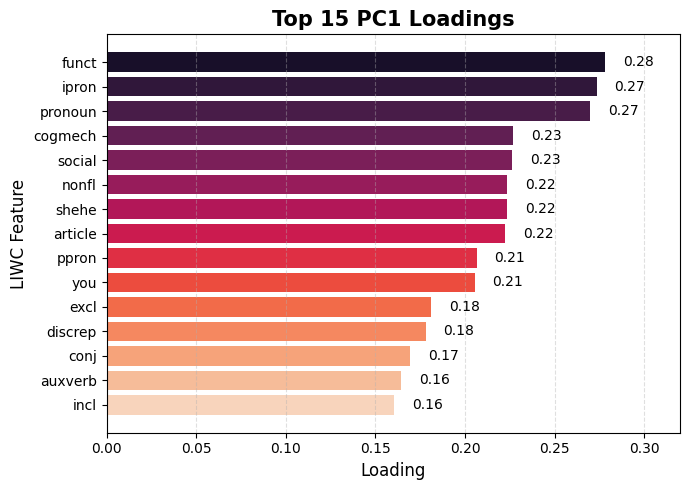

In [16]:
# Use seaborn's rocket palette for colors
palette = sns.color_palette("rocket", len(pc1_ld))

plt.figure(figsize=(7, 5))
bars = plt.barh(pc1_ld.index, pc1_ld['loading'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 PC1 Loadings", fontsize=15, weight='bold')
plt.xlabel("Loading", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with loading values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.01 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(0, 0.32)

plt.tight_layout()
plt.show()

In [17]:
# 6) L1 logistic features
lasso = l1_logistic_top(df, features, mask_adhd, n=15)
print("\nTop L1 logistic features:")
print(lasso[['coef']].to_markdown(floatfmt=".3f"))


Top L1 logistic features:
|         |   coef |
|:--------|-------:|
| achieve | -0.481 |
| negate  |  0.424 |
| cogmech | -0.385 |
| auxverb |  0.348 |
| past    | -0.332 |
| affect  |  0.236 |
| excl    | -0.228 |
| health  |  0.213 |
| pronoun | -0.198 |
| feel    |  0.172 |
| you     | -0.164 |
| space   | -0.162 |
| negemo  |  0.145 |
| humans  |  0.141 |
| relativ | -0.124 |


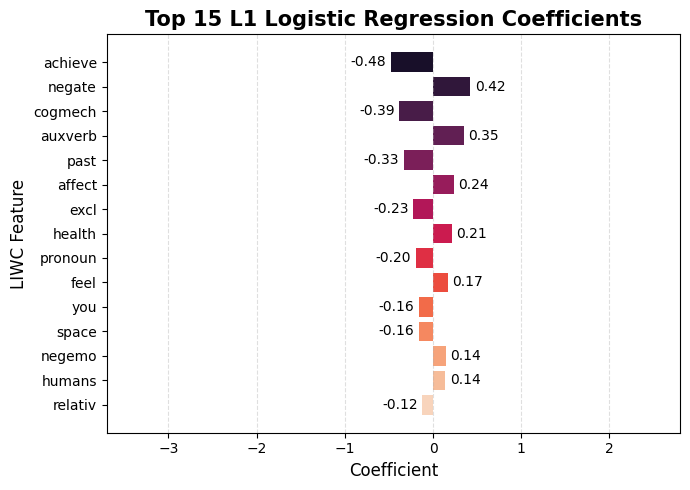

In [18]:
# Plotting top L1 logistic coefficients with seaborn's rocket palette
plt.figure(figsize=(7, 5))
palette = sns.color_palette("rocket", len(lasso))
bars = plt.barh(lasso.index, lasso['coef'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 L1 Logistic Regression Coefficients", fontsize=15, weight='bold')
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with coefficient values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.05 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(-3.7, 2.8)

plt.tight_layout()
plt.show()

In [19]:
# 7) Repeated CV for AUC stability
X = df[features].fillna(0).values
y = mask_adhd.astype(int).values
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
auc_scores = cross_val_score(clf, X, y, cv=rkf, scoring='roc_auc')
print(f"\nRepeated CV AUC: mean={auc_scores.mean():.3f}, SD={auc_scores.std():.3f}")


Repeated CV AUC: mean=0.504, SD=0.061


In [20]:
# 8) Stability selection via bootstrap Lasso
n_boot = 100
feat_counts = pd.Series(0, index=features)
for _ in range(n_boot):
    idx = np.random.choice(len(df), len(df), replace=True)
    Xb = X[idx]
    yb = y[idx]
    clf = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000)
    clf.fit(StandardScaler().fit_transform(Xb), yb)
    feat_counts += (np.abs(clf.coef_[0]) > 1e-6).astype(int)
stability = (feat_counts / n_boot).sort_values(ascending=False)
print("\nFeatures selected in ≥70% of bootstraps:")
print(stability[stability>=0.7].to_markdown(floatfmt=".2f"))


Features selected in ≥70% of bootstraps:
|         |    0 |
|:--------|-----:|
| achieve | 0.98 |
| negate  | 0.93 |
| conj    | 0.87 |
| cogmech | 0.85 |
| auxverb | 0.82 |
| we      | 0.81 |
| number  | 0.77 |
| health  | 0.76 |
| certain | 0.76 |
| negemo  | 0.74 |


## Analysis with Suspecting Females

In [21]:
df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-liwc-proportional.pkl")
mask_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis'].isin(["Sim, diagnosticado", "Estou em processo de diagnóstico", "Suspeito que tenho"]))
# , 
mask_others = ~mask_adhd
features = df.columns[-64:].tolist()

In [22]:
# 1) Univariate LIWC
uni = univariate_liwc(df, features, mask_adhd, mask_others)
print("\nLIWC dimensions |d| > 0.2:")
print(uni[uni['abs_cohen_d']>0.2].to_markdown(index=False, floatfmt=".3f"))


LIWC dimensions |d| > 0.2:
| feature   |   mean_g1 |   sd_g1 |   mean_g2 |   sd_g2 |   t_stat |   p_val |   bf10 |   cohen_d |   p_fdr | signif   |   abs_cohen_d |
|:----------|----------:|--------:|----------:|--------:|---------:|--------:|-------:|----------:|--------:|:---------|--------------:|
| negate    |     0.020 |   0.020 |     0.012 |   0.013 |    2.586 |   0.012 |  3.705 |     0.498 |   0.372 | False    |         0.498 |
| space     |     0.089 |   0.039 |     0.109 |   0.058 |   -2.574 |   0.011 |  3.598 |    -0.381 |   0.372 | False    |         0.381 |
| relativ   |     0.201 |   0.062 |     0.225 |   0.071 |   -2.267 |   0.025 |  1.848 |    -0.362 |   0.538 | False    |         0.362 |
| tentat    |     0.073 |   0.040 |     0.086 |   0.043 |   -1.972 |   0.051 |  1.053 |    -0.324 |   0.688 | False    |         0.324 |
| ingest    |     0.060 |   0.037 |     0.072 |   0.037 |   -1.927 |   0.057 |  0.974 |    -0.323 |   0.688 | False    |         0.323 |
| sad       |

In [23]:
# 2) Bootstrap CIs for features with |d| > 0.2
top_feats = uni[uni['abs_cohen_d'] > 0.2]['feature']
ci_list = []
for feat in top_feats:
    x = df.loc[mask_adhd, feat].dropna().values
    y = df.loc[mask_others, feat].dropna().values
    d_obs = cohen_d(x, y)
    lo, hi = bootstrap_ci(x, y, cohen_d, n_boot=2000, ci=95)
    ci_list.append({'feature': feat, 'd': d_obs, 'ci_lower': lo, 'ci_upper': hi})
ci_df = pd.DataFrame(ci_list)
print("\nBootstrap 95% CIs for Cohen's d (|d| > 0.2):")
print(ci_df.to_markdown(index=False, floatfmt=".3f"))


Bootstrap 95% CIs for Cohen's d (|d| > 0.2):
| feature   |      d |   ci_lower |   ci_upper |
|:----------|-------:|-----------:|-----------:|
| negate    |  0.498 |      0.159 |      0.831 |
| space     | -0.381 |     -0.649 |     -0.139 |
| relativ   | -0.362 |     -0.685 |     -0.049 |
| tentat    | -0.324 |     -0.650 |     -0.005 |
| ingest    | -0.323 |     -0.672 |      0.015 |
| sad       |  0.311 |     -0.026 |      0.674 |
| preps     | -0.297 |     -0.627 |      0.038 |
| past      | -0.274 |     -0.569 |      0.042 |
| health    |  0.251 |     -0.062 |      0.652 |
| assent    |  0.243 |     -0.202 |      0.533 |
| see       | -0.225 |     -0.521 |      0.042 |
| negemo    |  0.214 |     -0.116 |      0.570 |
| anx       |  0.200 |     -0.209 |      0.506 |


In [24]:
# 3) A priori power
req_n = a_priori_power(effect_size=0.6)
print(f"\nRequired N per group for d=0.6, α=0.05, 80% power: {req_n:.1f}")


Required N per group for d=0.6, α=0.05, 80% power: 44.6


In [25]:
# 4) PCA group differences
pc_res = pca_group_diff(df, features, mask_adhd, mask_others)
print("\nPCA group differences:")
print(pc_res.to_markdown(index=False, floatfmt=".3f"))


PCA group differences:
| PC   |   expl_var |   t_stat |   p_val |   p_fdr |
|:-----|-----------:|---------:|--------:|--------:|
| PC1  |      0.151 |   -0.536 |   0.593 |   0.658 |
| PC2  |      0.085 |   -0.443 |   0.658 |   0.658 |
| PC3  |      0.064 |   -1.416 |   0.160 |   0.658 |
| PC4  |      0.058 |   -0.544 |   0.588 |   0.658 |
| PC5  |      0.049 |    0.722 |   0.472 |   0.658 |


In [26]:
# 5) PCA group differences
pc1_ld = top_pc1_loadings(df, features, n=15)
print("\nTop PC1 loadings:")
print(pc1_ld[['loading']].to_markdown(floatfmt=".3f"))


Top PC1 loadings:
|         |   loading |
|:--------|----------:|
| funct   |     0.278 |
| ipron   |     0.273 |
| pronoun |     0.270 |
| cogmech |     0.227 |
| social  |     0.226 |
| nonfl   |     0.224 |
| shehe   |     0.223 |
| article |     0.222 |
| ppron   |     0.207 |
| you     |     0.205 |
| excl    |     0.181 |
| discrep |     0.178 |
| conj    |     0.169 |
| auxverb |     0.164 |
| incl    |     0.160 |


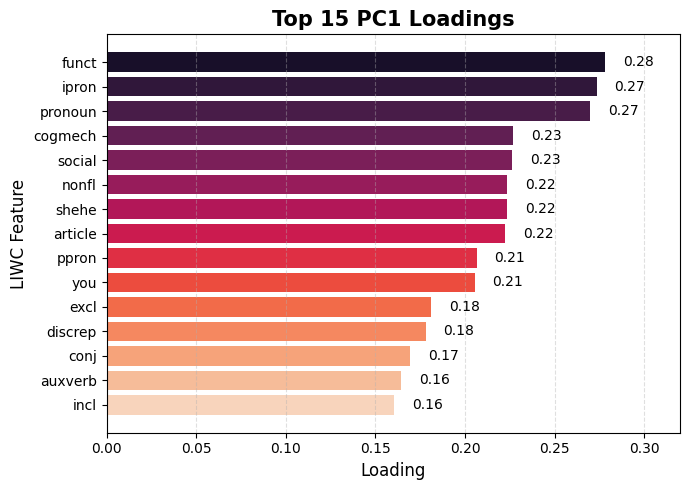

In [27]:
# Use seaborn's rocket palette for colors
palette = sns.color_palette("rocket", len(pc1_ld))

plt.figure(figsize=(7, 5))
bars = plt.barh(pc1_ld.index, pc1_ld['loading'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 PC1 Loadings", fontsize=15, weight='bold')
plt.xlabel("Loading", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with loading values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.01 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(0, 0.32)

plt.tight_layout()
plt.show()

In [28]:
# 6) L1 logistic features
lasso = l1_logistic_top(df, features, mask_adhd, n=15)
print("\nTop L1 logistic features:")
print(lasso[['coef']].to_markdown(floatfmt=".3f"))

/home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Top L1 logistic features:
|         |   coef |
|:--------|-------:|
| space   | -0.404 |
| negate  |  0.395 |
| ingest  | -0.308 |
| achieve | -0.258 |
| sad     |  0.232 |
| tentat  | -0.179 |
| time    |  0.162 |
| past    | -0.153 |
| bio     |  0.120 |
| health  |  0.100 |
| relativ | -0.080 |
| anx     |  0.079 |
| present |  0.079 |
| family  |  0.060 |
| humans  |  0.055 |


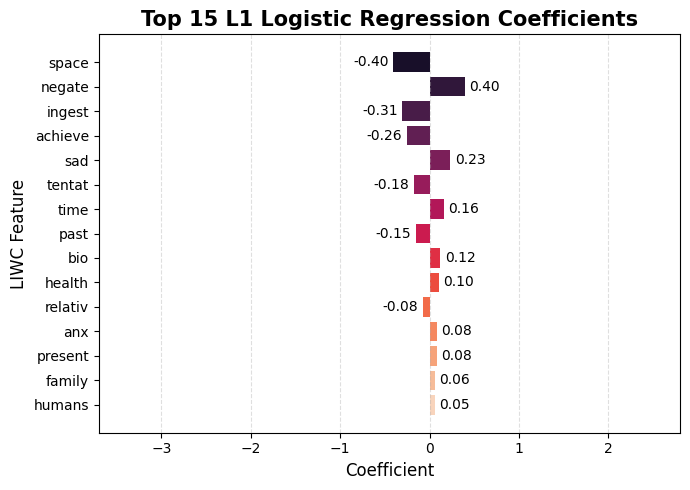

In [29]:
# Plotting top L1 logistic coefficients with seaborn's rocket palette
plt.figure(figsize=(7, 5))
palette = sns.color_palette("rocket", len(lasso))
bars = plt.barh(lasso.index, lasso['coef'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 L1 Logistic Regression Coefficients", fontsize=15, weight='bold')
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with coefficient values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.05 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(-3.7, 2.8)

plt.tight_layout()
plt.show()

In [30]:
# 7) Repeated CV for AUC stability
X = df[features].fillna(0).values
y = mask_adhd.astype(int).values
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
auc_scores = cross_val_score(clf, X, y, cv=rkf, scoring='roc_auc')
print(f"\nRepeated CV AUC: mean={auc_scores.mean():.3f}, SD={auc_scores.std():.3f}")


Repeated CV AUC: mean=0.497, SD=0.019


In [31]:
# 8) Stability selection via bootstrap Lasso
n_boot = 100
feat_counts = pd.Series(0, index=features)
for _ in range(n_boot):
    idx = np.random.choice(len(df), len(df), replace=True)
    Xb = X[idx]
    yb = y[idx]
    clf = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000)
    clf.fit(StandardScaler().fit_transform(Xb), yb)
    feat_counts += (np.abs(clf.coef_[0]) > 1e-6).astype(int)
stability = (feat_counts / n_boot).sort_values(ascending=False)
print("\nFeatures selected in ≥70% of bootstraps:")
print(stability[stability>=0.7].to_markdown(floatfmt=".2f"))


Features selected in ≥70% of bootstraps:
|         |    0 |
|:--------|-----:|
| negate  | 0.95 |
| space   | 0.93 |
| bio     | 0.91 |
| we      | 0.90 |
| future  | 0.89 |
| achieve | 0.88 |
| anger   | 0.86 |
| family  | 0.86 |
| ingest  | 0.84 |
| sad     | 0.77 |
| time    | 0.75 |
| death   | 0.74 |
| friend  | 0.73 |
| home    | 0.71 |
| inhib   | 0.71 |
| present | 0.70 |
| negemo  | 0.70 |
| preps   | 0.70 |
| sexual  | 0.70 |
